# **Stock Prediction by LSTM**

### **1. Import Libraries**

In [61]:
import os
import zipfile
import random
import itertools
import datetime
import math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from operator import itemgetter
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable

### **2. Load Datasets**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets'
data_name = 'AI Specialist Lesson 16.zip'
data_path = os.path.join(path, data_name)

os.mkdir('Lesson 16')
working_dir = os.path.join('/content', 'Lesson 16')
os.chdir(working_dir)

with zipfile.ZipFile(data_path, 'r') as data_zipfile:
  data_zipfile.extractall(working_dir)

In [4]:
for dirname,_,filenames in os.walk('AI Specialist Lesson 16'):
  for i, filenames in enumerate(filenames):
    if i<5:
      print(os.path.join(dirname, filenames))

AI Specialist Lesson 16/aapl.us.txt
AI Specialist Lesson 16/ibm.us.txt
AI Specialist Lesson 16/.DS_Store
AI Specialist Lesson 16/googl.us.txt


In [63]:
def stocks_data(symbols, dates):
  df = pd.DataFrame(index=dates)
  for symbol in symbols:
    # Đọc 3 file .txt, ở mỗi file chỉ lấy 2 cột 'Date' và 'Close'
    # 'Date' được lấy làm index cho frame, các giá trị na ký hiệu là 'nan'.
    df_temp = pd.read_csv('AI Specialist Lesson 16/{}.us.txt'.format(symbol), index_col='Date',
                          parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])

    # Đổi tên 3 cột có tên 'Close' như ở file ban đầu thành tên của hãng mà file đó đại diện
    df_temp = df_temp.rename(columns={'Close':symbol})

    # Kết hợp 3 frame thành 1
    df = df.join(df_temp)
  return df

,googl,ibm,aapl
2015-01-02,529.55,145.54,103.50
2015-01-05,519.46,143.24,100.58
2015-01-06,506.64,140.14,100.59
2015-01-07,505.15,139.23,102.01
2015-01-08,506.91,142.26,105.93
2015-01-09,500.72,142.88,106.04
2015-01-12,497.06,140.50,103.42
2015-01-13,501.80,140.82,104.35
2015-01-14,505.93,139.90,103.95
2015-01-15,504.01,138.81,101.12


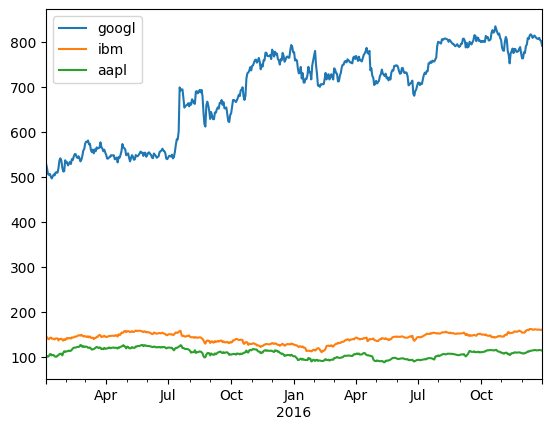

In [64]:
dates = pd.date_range('2015-01-02', '2016-12-31', freq='B')
symbols = ['googl', 'ibm', 'aapl']
df = stocks_data(symbols, dates)
df = df.fillna(method='pad') # fillna bằng giá trị phía trước nó
display(df.head(15))
df.interpolate().plot()
plt.show()

>**Note:**
* Trong bài này ta chỉ dự đoán giá đóng cửa (cột Close) cổ phiếu của IBM.

In [65]:
# Visualize các giá trị trong file của ibm
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1 = pd.DataFrame(index=dates)
display(df1.head())
df_ibm = pd.read_csv('AI Specialist Lesson 16/ibm.us.txt', parse_dates=True, index_col=0)
display(df_ibm.head())

""
2010-01-04
2010-01-05
2010-01-06
2010-01-07
2010-01-08


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1962-01-02,6.4130,6.4130,6.3378,6.3378,467056,0
1962-01-03,6.3378,6.3963,6.3378,6.3963,350294,0
1962-01-04,6.3963,6.3963,6.3295,6.3295,314365,0
1962-01-05,6.3211,6.3211,6.1958,6.2041,440112,0
1962-01-08,6.2041,6.2041,6.0373,6.0870,655676,0


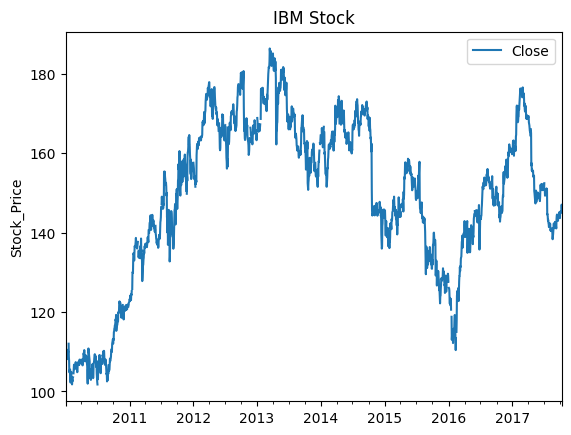

In [66]:
df_ibm = df1.join(df_ibm) # DF chứa thông tin cổ phiếu của IBM trong khoảng thời gian từ 2010-01-02 đến 2017-10-11.
df_ibm[['Close']].plot()
plt.ylabel('Stock_Price')
plt.title('IBM Stock')
plt.show()

In [67]:
display(df_ibm.head())

,Open,High,Low,Close,Volume,OpenInt
2010-01-04,109.55,111.03,109.26,110.59,7371472.0,0.0
2010-01-05,109.95,110.11,108.65,109.26,8193158.0,0.0
2010-01-06,109.12,109.81,108.39,108.56,6712810.0,0.0
2010-01-07,108.45,108.77,107.65,108.19,6995459.0,0.0
2010-01-08,107.76,109.31,107.75,109.26,5019238.0,0.0


In [68]:
df_ibm = df_ibm[['Close']]
display(df_ibm.head())

,Close
2010-01-04,110.59
2010-01-05,109.26
2010-01-06,108.56
2010-01-07,108.19
2010-01-08,109.26


In [69]:
df_ibm.describe()

,Close
count,1958.000000
mean,148.695112
std,20.453513
min,101.740000
25%,137.795000
50%,151.500000
75%,165.407500
max,186.360000


In [70]:
df_ibm = df_ibm.fillna(method='ffill') # forward fill: fill tới

# Chuẩn hóa các giá trị cột Close về khoảng (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1, 1))

In [71]:
df_ibm.describe()

,Close
count,2028.000000
mean,0.109940
std,0.483132
min,-1.000000
25%,-0.147306
50%,0.177027
75%,0.504668
max,1.000000


### **3. Create train, test data**

In [72]:
def load_data(stock, look_back):
  # look_back=N ở đây là độ dài của cửa sổ, cửa sổ này trượt trên data
  data_raw = stock.values # convert to numpy array
  data = []

  # create all possible sequences of length seq_len
  # cho cửa sổ có chiều dài = look_back trượt từ đầu đến cuối data_raw
  # các khối N sample gối đầu lên nhau thu được sẽ đưa vào data (list ban đầu là rỗng)
  for index in range(len(data_raw)-look_back):
    data.append(data_raw[index:index+look_back])

  data = np.array(data)
  test_set_size = int(np.round(0.2*data.shape[0]))
  train_set_size = data.shape[0]-test_set_size

  x_train = data[:train_set_size, :-1, :] # trong 1 khối N sample, lấy N-1 sample để train
  y_train = data[:train_set_size, -1, :]

  x_test = data[train_set_size:, :-1]
  y_test = data[train_set_size:, -1, :]

  return [x_train, y_train, x_test, y_test]

In [73]:
# Mục đích là ta dùng 19 giá trị trong look_back để dự đoán 1 giá trị còn lại
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1606, 19, 1)
y_train.shape =  (1606, 1)
x_test.shape =  (402, 19, 1)
y_test.shape =  (402, 1)


In [74]:
print(x_train[1])

[[-0.82226424]
 [-0.83880879]
 [-0.84755377]
 [-0.82226424]
 [-0.84920823]
 [-0.82935476]
 [-0.83408178]
 [-0.79342945]
 [-0.80359253]
 [-0.80359253]
 [-0.75726779]
 [-0.83384543]
 [-0.85889861]
 [-0.92767667]
 [-0.91515008]
 [-0.92271331]
 [-0.91113212]
 [-0.96242023]
 [-0.98889152]]


In [75]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [76]:
y_train.size(), x_train.size()

(torch.Size([1606, 1]), torch.Size([1606, 19, 1]))

In [77]:
# khi dùng batch size bắt buộc phải có dataloader để chia tự động
n_steps = look_back-1
batch_size = 1606
num_epochs = 100

train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=False)
test_load = torch.utils.data.DataLoader(dataset=test,
                                        batch_size=batch_size,
                                        shuffle=False)

In [78]:
# data --> tensor --> dataset --> dataloader --> training

### **4. Build Model**

In [79]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

# Define model as a class
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    # Hidden dimensions
    self.hidden_dim = hidden_dim

    # Number of hidden layers
    self.num_layers = num_layers

    # Building your LSTM
    # batch_first=True causes input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    # Reload layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # Initialize hidden state with zeros
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    # Initialize cell state
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

    # One time step
    # We need to detach as we are doing truncated backpropagation through time (BPTT)
    # If we don't, we'll backprop all the way to the start even after going through another batch
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

    # Index hidden state of last time step
    # out.size() --> 100, 28, 100
    # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
    out = self.fc(out[:, -1, :])
    # out.size() --> 100, 10
    return out

In [80]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,
             output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
  print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### **5. Train Model**

In [81]:
hist = np.zeros(num_epochs)

# Number of step to unroll
seq_dim = look_back-1

for t in range(num_epochs):
  # Initialise hidden state
  # Don't do this if you want your LSTM to be stateful
  # model.hidden = model.init_hidden()

  # Forward pass
  y_train_pred = model(x_train)

  loss = loss_fn(y_train_pred, y_train)
  if t%10==0 and t!=0:
    print('Epoch ', t, 'MSE: ', loss.item())
  hist[t] = loss.item()

  # Zero out gradient, else they will accumulate between epochs
  optimizer.zero_grad()

  # Backward pass
  loss.backward()

  # Update parameters
  optimizer.step()

Epoch  10 MSE:  0.019658099859952927
Epoch  20 MSE:  0.018687017261981964
Epoch  30 MSE:  0.008315407671034336
Epoch  40 MSE:  0.006184321362525225
Epoch  50 MSE:  0.0047524659894406796
Epoch  60 MSE:  0.004328194539994001
Epoch  70 MSE:  0.003921124152839184
Epoch  80 MSE:  0.0036828224547207355
Epoch  90 MSE:  0.003501895349472761


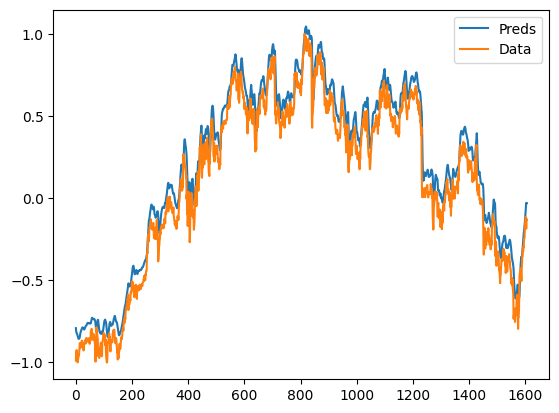

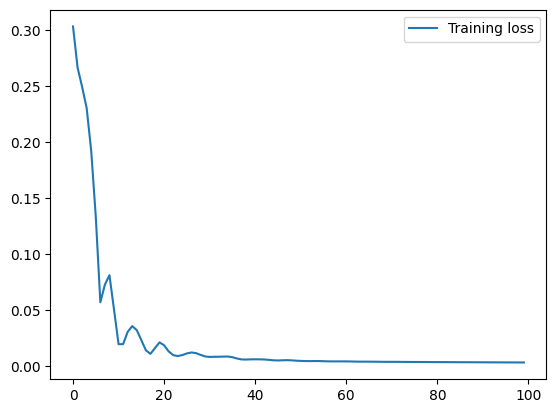

In [82]:
plt.plot(y_train_pred.detach().numpy() + 0.1, label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [83]:
np.shape(y_train_pred)

torch.Size([1606, 1])

In [84]:
# Make Predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()) # Biến đổi ngược quá trình scaler vào khoảng (-1, 1) lúc đầu, đưa các giá trị về như ban đầu
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# Caculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.45 RMSE
Test Score: 1.89 RMSE


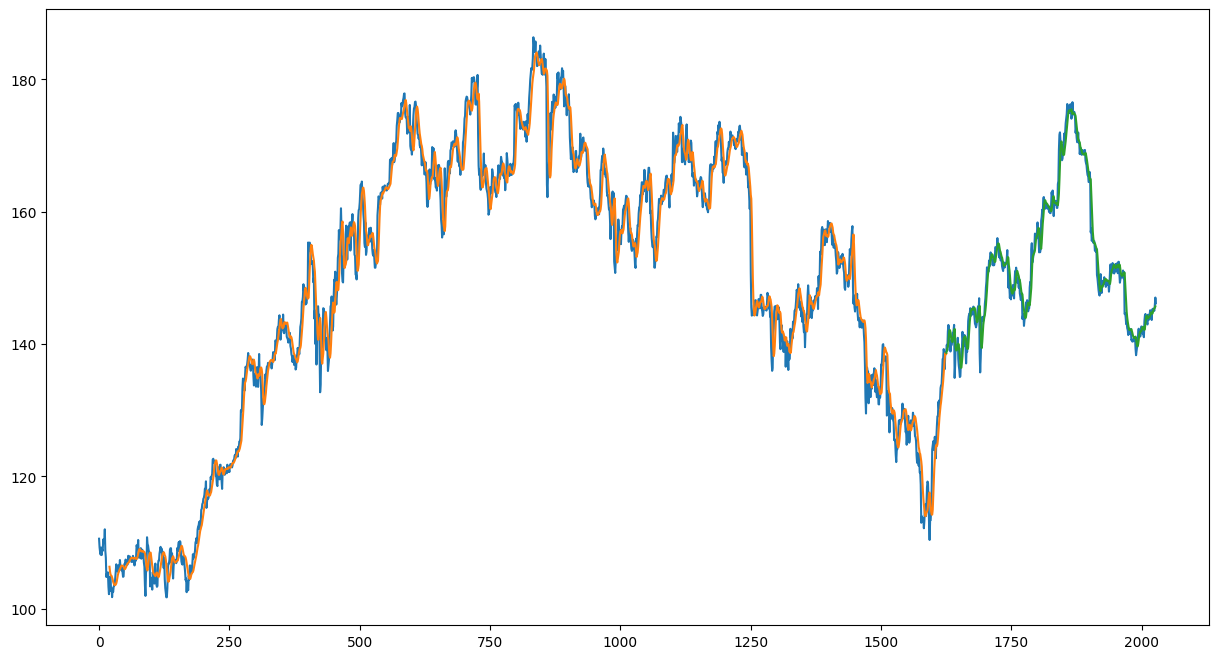

In [85]:
# shift(biến đổi) train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_ibm)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()